## Goal

Wrangle, analyze and visualize tweet archive of Twitter user @dog_rates, also known as WeRateDogs.
 


## Table of Contents
- [Gather](#gather)
- [Assess](#assess)
- [Clean](#clean)
- [Store](#store)
- [Analysis & Visualization](#analysevisualize)

<a id='gather'></a>
## Gather

In [1489]:
#Import the required libraries to load the dataset
import pandas as pd
import numpy as np
import requests as rqst
import json
import tweepy
import os

#disable warnings
import warnings
warnings.filterwarnings('ignore')

#Import libraries for plotting
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
from matplotlib import style



In [1165]:
#Load the enhanced Twitter archive of WeRateDogs
dog_ratings= pd.read_csv(r'twitter-archive-enhanced.csv' )

In [1166]:
dog_ratings.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [ ]:
#download the tweet image predictions file from the url
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response=rqst.get(url)

with open(url.split('/')[-1],mode='wb') as file:
    file.write(response.content)

In [1167]:
#Then read in the downloaded tsv file
img_predictions= pd.read_csv(r'image-predictions.tsv',sep='\t' )
img_predictions.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


### Query Twitter data

Set up a Twitter application and hence create an API object that will be used to gather Twitter data.

In [4]:
consumer_key = 'MY CONSUMER KEY'
consumer_secret = 'MY CONSUMER SECRET'
access_token = 'MY ACCESS TOKEN'
access_secret = 'MY ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token_key, access_secret)

#set rate limit parameters for the API to True.Rate limits are divided into 15 minute intervals.
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify =True)


In [10]:
#Query each tweet id and write its json data into tweet_json.txt with each tweet's json data in its own line.
#import codecs
from timeit import default_timer as timer

tweet_tmr_lst=[]
excp_lst=[]
with open('tweet_json.txt','w',encoding='utf-8') as jsnfile:
    for tweetid in dog_ratings['tweet_id']:
        try:
            start = timer()
            tweet=api.get_status(tweetid,tweet_mode='extended')
            json.dump(tweet._json,jsnfile)
            jsnfile.write('\n')
            end = timer()
            tweet_tmr_lst.append({tweetid:(end-start)})
        except:
            excp_lst.append(tweetid)
            continue
    print('all done')

all done


In [1168]:
#Read the json data in to a list
tweet_data=[]
with open('tweet_json.txt','r') as tweetf:
    for line in tweetf:
        tweetj=json.loads(line)
        tweet_data.append(tweetj)

In [16]:
#missing tweets
len(excp_lst)

11

In [7]:
#Total number of tweets
len(tweet_data)

2345

In [1169]:
#Create a dataframe
tweet_data_df=pd.DataFrame()

In [1170]:
#Add three new columns to the additional data scraped
tweet_data_df['tweet_id']=[tweet['id']for tweet in tweet_data]
tweet_data_df['retweet_count']=[tweet['retweet_count']for tweet in tweet_data]
tweet_data_df['favourite_count']=[tweet['favorite_count']for tweet in tweet_data]

In [1171]:
tweet_data_df.head()

,tweet_id,retweet_count,favourite_count
0,892420643555336193,8571,38736
1,892177421306343426,6300,33193
2,891815181378084864,4184,24995
3,891689557279858688,8697,42139
4,891327558926688256,9460,40277


At the end of gather stage, we have three dataframes
1. Enhanced twitter data
       dog_ratings
2. Image predictions data
       img_predictions
3. Additional twitter data
       tweet_data_df

<a id='assess'></a>
## Assess

In [1902]:
#Visually check the contents of the dataframe
dog_ratings.sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
887,759923798737051648,NaN,NaN,2016-08-01 01:28:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs... this is a Taiwanese Guide...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/759923798...,10,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None


In [1903]:
#Assess the data in the enhanced Twitter archive :datatype,row and columns and their count, missing values
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [1904]:
#filter on the non null values for the retweet related columns.
dog_ratings[dog_ratings.retweeted_status_id.notnull()].sample(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
605,798576900688019456,NaN,NaN,2016-11-15 17:22:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Not familiar with this breed. N...,6.661041e+17,4.196984e+09,2015-11-16 04:02:55 +0000,https://twitter.com/dog_rates/status/666104133...,1,10,None,None,None,None,None
829,768909767477751808,NaN,NaN,2016-08-25 20:35:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: When it's Janet from accounting...,7.001438e+17,4.196984e+09,2016-02-18 02:24:13 +0000,https://twitter.com/dog_rates/status/700143752...,10,10,None,None,None,pupper,None


In [1905]:
#Count of tweet entries which are not original tweets.
dog_ratings[dog_ratings.retweeted_status_id.notnull()].count()['retweeted_status_id']

181

In [1906]:
#Check for duplicate rows
sum(dog_ratings.duplicated() )

0

In [1907]:
dog_ratings[dog_ratings.in_reply_to_status_id.notnull()].head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [1908]:
#Check for non-names of dogs
dog_ratings.name.value_counts().head(10)

None       745
a           55
Charlie     12
Cooper      11
Lucy        11
Oliver      11
Lola        10
Penny       10
Tucker      10
Bo           9
Name: name, dtype: int64

In [1909]:
dog_ratings[dog_ratings.name.str.islower()]['name'].head(10)

22           such
56              a
118         quite
169         quite
193         quite
335           not
369           one
542    incredibly
649             a
682           mad
Name: name, dtype: object

In [1910]:
#check the dog stage columns -doggo,floofer,puppo,pupper  which donot have any value or does not indicate the dog stage
dog_ratings[(dog_ratings.doggo =='None')&(dog_ratings.floofer =='None')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='None') ].head(4)[['tweet_id','doggo','floofer','puppo','pupper','name']]

,tweet_id,doggo,floofer,puppo,pupper,name
0,892420643555336193,None,None,None,None,Phineas
1,892177421306343426,None,None,None,None,Tilly
2,891815181378084864,None,None,None,None,Archie
3,891689557279858688,None,None,None,None,Darla


In [1911]:
#Count of entries which does'nt have any dog stage mentioned.
len(dog_ratings[(dog_ratings.doggo =='None')&(dog_ratings.floofer =='None')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='None') ])

1976

In [1912]:
#atleast one entry in the dog stage columns
dog_stage_val=len(dog_ratings[(dog_ratings.doggo =='doggo')|(dog_ratings.floofer =='floofer')|(dog_ratings.puppo =='puppo')|(dog_ratings.pupper =='pupper') ])
dog_stage_val

380

In [1913]:
# Cross check the record with atleast one dog stage entry
dog_stage_val==dog_ratings.shape[0]  - (len(dog_ratings[(dog_ratings.doggo =='None')&(dog_ratings.floofer =='None')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='None') ]))

True

In [1914]:
#Multiple dog stage captured for a single tweet
L1=len(dog_ratings[(dog_ratings.doggo =='doggo')&(dog_ratings.floofer =='floofer')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='None')])
L2=len(dog_ratings[(dog_ratings.doggo =='doggo')&((dog_ratings.floofer =='None')&(dog_ratings.puppo =='puppo')&(dog_ratings.pupper =='None')) ])
L3=len(dog_ratings[(dog_ratings.doggo =='doggo')&((dog_ratings.floofer =='None')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='pupper')) ])

L1,L2,L3


(1, 1, 12)

In [1915]:
#Random check for more than one dog stage
dog_ratings[(dog_ratings.doggo =='doggo') &(dog_ratings.puppo =='puppo')][['tweet_id','doggo','floofer','puppo','pupper','name']]

,tweet_id,doggo,floofer,puppo,pupper,name
191,855851453814013952,doggo,None,puppo,None,None


In [1916]:
#only doggo
doggo_count=len(dog_ratings[(dog_ratings.doggo =='doggo')&(dog_ratings.floofer =='None')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='None') ])
doggo_count

83

In [1917]:
#floofer
floofer_count=len(dog_ratings[(dog_ratings.floofer =='floofer')&(dog_ratings.doggo =='None')&(dog_ratings.puppo =='None')&(dog_ratings.pupper =='None') ])
floofer_count

9

In [1918]:
#pupper
pupper_count=len(dog_ratings[(dog_ratings.pupper =='pupper')&(dog_ratings.doggo =='None')&(dog_ratings.puppo =='None')&(dog_ratings.floofer =='None')])
pupper_count

245

In [1919]:
#puppo
puppo_count=len(dog_ratings[(dog_ratings.puppo =='puppo')&(dog_ratings.doggo =='None')&(dog_ratings.pupper =='None')&(dog_ratings.floofer =='None') ])
puppo_count

29

In [1920]:
#Random checks show that more than one dog stage is mentioned in a tweet for the same dog, but reading the text
#gives the complete picture.
dog_ratings[(dog_ratings.doggo =='doggo')&((dog_ratings.floofer =='floofer')|(dog_ratings.puppo =='puppo')|(dog_ratings.pupper =='pupper')) ].sample(10)[['tweet_id','doggo','floofer','puppo','pupper','name']]

,tweet_id,doggo,floofer,puppo,pupper,name
822,770093767776997377,doggo,None,None,pupper,just
1113,733109485275860992,doggo,None,None,pupper,None
565,802265048156610565,doggo,None,None,pupper,None
705,785639753186217984,doggo,None,None,pupper,Pinot
778,775898661951791106,doggo,None,None,pupper,None
531,808106460588765185,doggo,None,None,pupper,None
460,817777686764523521,doggo,None,None,pupper,Dido
733,781308096455073793,doggo,None,None,pupper,None
200,854010172552949760,doggo,floofer,None,None,None
191,855851453814013952,doggo,None,puppo,None,None


In [1921]:
#Unique source of tweets
dog_ratings.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [1922]:
#Asses ratings columns for denominator and numertaor.Since WeRatedogs have unique rating system where
#numerator rating is in excess of denominator
dog_ratings[dog_ratings['rating_denominator']>10].head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
342,832088576586297345,8.320875e+17,30582082.0,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


In [1929]:
#Varied denominator values with max value of 170 and there is eveb a 0
dog_ratings.rating_denominator.value_counts().sort_values(ascending=False)

10     2333
11        3
50        3
80        2
20        2
7         1
2         1
16        1
40        1
0         1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
70        1
Name: rating_denominator, dtype: int64

In [1924]:
#Varied numerator values >10 and max value of 1776.
dog_ratings.rating_numerator.value_counts().sort_values(ascending=False)

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
121       1
80        1
204       1
24        1
143       1
99        1
45        1
27        1
17        1
1776      1
960       1
666       1
182       1
26        1
144       1
88        1
84        1
165       1
60        1
50        1
44        1
20        1
Name: rating_numerator, dtype: int64

Looking at the unique rating system we see that there are extreme values for denominator and numerator.Good and better ratings seems to be greater numerator(>10) and lower denominator values.

In [1925]:
#Difference in total records and jpg_url column containing string .jpg in the column values
img_predictions_clean.shape[0] - img_predictions[img_predictions['jpg_url'].str.contains('.jpg')].shape[0]

2

In [1926]:
#image urls that cannot be accessed.
img_predictions[~img_predictions['jpg_url'].str.contains('.jpg')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
320,671789708968640512,https://pbs.twimg.com/tweet_video_thumb/CVKtH-...,1,dalmatian,0.114259,True,teddy,0.062275,False,steam_locomotive,0.049700,False
815,692752401762250755,https://pbs.twimg.com/tweet_video_thumb/CZ0mhd...,1,Samoyed,0.471276,True,Siberian_husky,0.158850,True,Eskimo_dog,0.138672,True


In [1927]:
#urls that doesnt contain string .jpg but a .png extension.

img_predictions[img_predictions['tweet_id']==671789708968640512].jpg_url.value_counts(),img_predictions[img_predictions['tweet_id']==692752401762250755].jpg_url.value_counts()

(https://pbs.twimg.com/tweet_video_thumb/CVKtH-4WIAAmiQ5.png    1
 Name: jpg_url, dtype: int64,
 https://pbs.twimg.com/tweet_video_thumb/CZ0mhduWkAICSGe.png    1
 Name: jpg_url, dtype: int64)

In [1928]:
#View the data details
img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [1199]:
#field/variable of interest-mixed case in string values
img_predictions.p1.value_counts().head()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
Name: p1, dtype: int64

In [810]:
#Confidence level of the primary prediction
img_predictions.query('p1_dog==True').sort_values('p1_conf',ascending=False).head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
149,668636665813057536,https://pbs.twimg.com/media/CUd5gBGWwAA0IVA.jpg,1,komondor,0.999956,True,llama,0.000043,False,ram,2.160900e-07,False
1372,762464539388485633,https://pbs.twimg.com/media/CpTRc4DUEAAYTq6.jpg,4,chow,0.999953,True,Tibetan_mastiff,0.000023,True,dhole,3.010330e-06,False
865,697463031882764288,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,8.267760e-06,True
475,675149409102012420,https://pbs.twimg.com/media/CV6czeEWEAEdChp.jpg,1,chow,0.999876,True,Tibetan_mastiff,0.000059,True,Tibetan_terrier,2.877850e-05,True
1014,709566166965075968,https://pbs.twimg.com/media/Cdjiqi6XIAIUOg-.jpg,1,chow,0.999837,True,Tibetan_mastiff,0.000117,True,Australian_terrier,1.133840e-05,True


In [1200]:
#Records correctly predicted as dog.
img_predictions.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [1201]:
#Record count where all three predictions for dog failed.
img_predictions.query('p1_dog==False' and 'p2_dog==False' and 'p3_dog==False').count()['jpg_url']

576

In [1202]:
#View failed primary dog prediction.
img_predictions.query('p1_dog==False' and 'p2_dog==False' and 'p3_dog==False').head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False


In [1203]:
img_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


p2_conf and p3_conf - confidence level prediction is very low in second and third level prediction compared to p1_conf -first/primary prediction.

In [1204]:
tweet_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id           2345 non-null int64
retweet_count      2345 non-null int64
favourite_count    2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [1205]:
tweet_data_df.describe()

,tweet_id,retweet_count,favourite_count
count,2.345000e+03,2345.000000,2345.000000
mean,7.422940e+17,3018.759062,8052.624307
std,6.833642e+16,5021.235071,12118.217376
min,6.660209e+17,0.000000,0.000000
25%,6.783802e+17,606.000000,1404.000000
50%,7.189392e+17,1406.000000,3529.000000
75%,7.986979e+17,3511.000000,9954.000000
max,8.924206e+17,77209.000000,143141.000000


### Observations
Assessment of the data with respect to quality and tidiness are listed below-

**Quality Issues**

1. NaN values and non null values in the columns - 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp'

2. Incorrect datatype for columns :in_reply_to_status_id, in_reply_to_user_id and timestamp

3. Non descriptive column headers in dog_ratings dataframe:  doggo,floofer,pupper,puppo and names are not intuitive.

4. Not all tweets have dog name(s) captured.Many non-name entries like a, None,officially,quite,etc are included.

5. The columns :doggo,floofer,pupper,puppo indicates dog stage for the supposed dog mentioned in the tweet but there are tweet_ids where no dog stage has been captured and some of the tweets have more than one dog stage captured for the same mention.Also the column header names are non descriptive.

6. Source can be made explicit instead of the html string, from a analysis and visualization perspective.

7. Tweet id count in the img_predictions does not tally with that of the enhanced twitter data-Original tweets from enhanced twitter data to be matched against img_predictions indicating we need original tweets with images only.

8. Non descriptive column header -'jpg_urls' in image predictions data.

9. Inconsistent case -the dog breeds under p1,p2and p3 prediction columns have dog breeds in title case and also in lower case.

10. Mismatch in the tweet id count between enhanced twitter data and additional twitter data.




**Tidiness issues**

1. Variables : doggo,floofer,pupper and puppo  can be categorized under 'dog stages'.

2. enhanced twitter data and additional twitter data captured under dog_ratings_clean and tweet_data_df respectively can be merged.

3. Timestamp column can be split into date and time columns.

4. Dog breeds captured in img_predictions dataframe under p1,p2,p3 can be categorised under a  single column.


<a id='clean'></a>
## Clean

### Solution -Quality and Tidiness

In [1938]:
#Make copy of each of the dataframes so as to clean the dirty data
dog_ratings_clean=dog_ratings.copy()
img_predictions_clean=img_predictions.copy()
tweet_data_df=tweet_data_df.copy()

### Define

 NaN and non-null values in the columns - 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' 

Retweet related columns has NaN values as these are original tweets.The above columns relating to retweet with non-null values  stores the representation of the original tweet indicating these entries are retweets, ie these have non-null values and we donot need retweets.Now we have to identify non-null values in these columns and remove them.

### Code

In [1939]:
#Count of retweets.Columns related to retweets() have 
retweet_count=dog_ratings_clean[dog_ratings_clean.retweeted_status_id.notnull()].count()['retweeted_status_id']
retweet_count

181

In [1940]:
dog_ratings_clean.shape[0]

2356

In [1942]:
#Original tweet count
dog_ratings_clean.shape[0] - retweet_count

2175

In [1941]:
#Sample of retweets
dog_ratings_clean[dog_ratings_clean.retweeted_status_id.notnull()][['tweet_id','retweeted_status_id', 'retweeted_status_user_id','retweeted_status_timestamp']].sample(3)

,tweet_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
535,807059379405148160,7.829691e+17,4.196984e+09,2016-10-03 15:42:44 +0000
890,759566828574212096,7.395441e+17,4.196984e+09,2016-06-05 19:47:03 +0000
822,770093767776997377,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000


In [1943]:
#Filter the records which are retweets
dog_ratings_clean=dog_ratings_clean[~dog_ratings_clean.retweeted_status_id.notnull()]
dog_ratings_clean.count()['retweeted_status_id']

0

### Test

In [1944]:
#cross check to confirm the changes -should be zero
dog_ratings_clean[dog_ratings_clean.retweeted_status_id.notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [1516]:
dog_ratings_clean.shape[0]

2175

In [1945]:
dog_ratings_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1



### Define

*Invalid datatype* -'timestamp' column needs to be in datetime format.in_reply_to_status_id and in_reply_to_user_id columns are in float format but we will not be using them in the analysis we will not consider the columns,hence not converting them to class type int.

### Code

In [1946]:
#Convert to datetime format
dog_ratings_clean['timestamp']=pd.to_datetime(dog_ratings_clean['timestamp'])

In [1947]:
#Exclude the columns-.in_reply_to_status_id and in_reply_to_user_id columns  which are not required for our analysis
dog_ratings_clean=dog_ratings_clean[['tweet_id','timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo']]

### Test

In [1949]:
#confirm the changes
dog_ratings_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 15 columns):
tweet_id                      2175 non-null int64
timestamp                     2175 non-null datetime64[ns]
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(9)
memory usage: 271.9+ KB


###  Define

3.The four columns - doggo,floofer,pupper,puppo, refers to dog stages.Some of the tweets have more than one dog stage mentioned and there are tweets where no dog stage info is captured. Considering that the 'text' column  has reference to dog stage(s),this  can be extracted and checked for analysis and visualization.

3.1 Identify tweets with non null and null values in dog stage columns.

3.2 Categorize the tweets with non null values:only individual values and more than one value against the 4 columns.

3.3 For tweets with more than one dog stages, check and confirm that they are valid.

3.4 Melt the 4 dog stage columns into one and remove any none values.

3.5 Extract the dog stages (if any) from the 'text' column for tweets with 'None' values in the 4 dog stage columns and create a separate column.Here the 'true' None values are retained.

3.6 Concatenate the two dataframes.

Aside, looks like the dog stages captured through the 4 columns -doggo,puppo,pupper and floofer have been extracted from the 'text' column.The validity in terms of the context of dog stage usage and its reference is not clear,as there is no separate field where the dog stage is identified concretely.

Note - The quality issue identified ie non descriptive column 'name' and presence of non-name entries will not be cleaned. Renaming the column 'name' and identifying the non names and possible replacing the 'non names' like None(680 count),the,a,an,etc with 'name' column values being extracted from  the text column (containing the tweet) will not be executed.This note has been mentioned to highlight that the  column'name' will not be used and hence will be excluded from the cleaning.

### Code

In [1950]:
#Exclude the column-name with quality issues as this column will not be used for further analysis.
dog_ratings_clean[dog_ratings_clean.name.str.islower()]['name'].value_counts()

a               55
the              8
an               6
one              4
very             4
just             3
quite            3
not              2
getting          2
actually         2
mad              1
incredibly       1
life             1
officially       1
this             1
by               1
such             1
his              1
space            1
infuriating      1
my               1
all              1
unacceptable     1
old              1
light            1
Name: name, dtype: int64

In [1951]:
dog_ratings_clean=dog_ratings_clean[['tweet_id', 'timestamp', 'source', 'text', 'retweeted_status_id',
       'retweeted_status_user_id', 'retweeted_status_timestamp',
       'expanded_urls', 'rating_numerator', 'rating_denominator',
       'doggo', 'floofer', 'pupper', 'puppo']]

In [1952]:
#1. Identify tweets with more than one dog stage
dog_stage=dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&((dog_ratings_clean.floofer =='floofer')|(dog_ratings_clean.puppo =='puppo')|(dog_ratings_clean.pupper =='pupper')) ].sample(4)[['tweet_id','doggo','floofer','puppo','pupper','text']]
dog_stage

,tweet_id,doggo,floofer,puppo,pupper,text
1063,741067306818797568,doggo,None,None,pupper,This is just downright precious af. 12/10 for ...
531,808106460588765185,doggo,None,None,pupper,Here we have Burke (pupper) and Dexter (doggo)...
1113,733109485275860992,doggo,None,None,pupper,"Like father (doggo), like son (pupper). Both 1..."
200,854010172552949760,doggo,floofer,None,None,"At first I thought this was a shy doggo, but i..."


In [1953]:
#Count of entries which does'nt have any dog stage mentioned.
none_dog_stage=len(dog_ratings_clean[(dog_ratings_clean.doggo =='None')&(dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None') ])
none_dog_stage

1831

In [1954]:
dog_ratings_clean.shape[0]

2175

In [1955]:
##This data in comments are from Assess section using dog_ratings dataframe.
#dog_stage_val -rows with atleast one dog stage mentioned.
#L1,L2,L3 are the rows more than one dog stage mentioned --total count 14
#pupper_count,floofer_count,puppo_count,doggo_count - row with the specific dog stage only
dog_stage_val ==(L1+L2+L3)+pupper_count+floofer_count+puppo_count+doggo_count

True

In [1527]:
#Atleast one dog stage.
dog_stage_val_clean=len(dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')|(dog_ratings_clean.floofer =='floofer')|(dog_ratings_clean.puppo =='puppo')|(dog_ratings_clean.pupper =='pupper') ])
dog_stage_val_clean

344

In [1956]:
#Multiple dog stage captured for a single tweet
L1_cl=len(dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&(dog_ratings_clean.floofer =='floofer')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None')])
L2_cl=len(dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&((dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='puppo')&(dog_ratings_clean.pupper =='None')) ])
L3_cl=len(dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&((dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='pupper')) ])
L1_cl,L2_cl,L3_cl

(1, 1, 10)

In [1957]:
# Cross check the record with atleast one dog stage entry
dog_stage_val_clean==dog_ratings_clean.shape[0]  - none_dog_stage

True

In [1958]:
#individual dog stage count
doggo_count_cl=len(dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&(dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None') ])

floofer_count_cl=len(dog_ratings_clean[(dog_ratings_clean.floofer =='floofer')&(dog_ratings_clean.doggo =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None') ])

pupper_count_cl=len(dog_ratings_clean[(dog_ratings_clean.pupper =='pupper')&(dog_ratings_clean.doggo =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.floofer =='None')])

puppo_count_cl=len(dog_ratings_clean[(dog_ratings_clean.puppo =='puppo')&(dog_ratings_clean.doggo =='None')&(dog_ratings_clean.pupper =='None')&(dog_ratings_clean.floofer =='None') ])

doggo_count_cl,floofer_count_cl,pupper_count_cl,puppo_count_cl

(75, 9, 224, 24)

In [1959]:
#Identify the correct dog stage from the text 
#rec1=dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&(dog_ratings_clean.floofer =='floofer')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None')]
dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&(dog_ratings_clean.floofer =='floofer')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None')][['tweet_id','doggo','floofer','puppo','pupper','text']]


,tweet_id,doggo,floofer,puppo,pupper,text
200,854010172552949760,doggo,floofer,None,None,"At first I thought this was a shy doggo, but i..."


In [1961]:
#From the text and also check the corresponding image -L1_cl :1
dog_ratings_clean[dog_ratings_clean['tweet_id']==854010172552949760]['text'].value_counts()

At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk    1
Name: text, dtype: int64

In [1259]:
#Replace 'floofer' with None
#dog_ratings_clean.loc[200,dog_ratings_clean.columns[12]]=None

In [1260]:
#Confirm the changes
#dog_ratings_clean[dog_ratings_clean['tweet_id']==854010172552949760]['floofer']

200    floofer
Name: floofer, dtype: object

In [1533]:
#Identify the correct dog stage from the rows - L2_cl:1
(dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&((dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='puppo')&(dog_ratings_clean.pupper =='None')) ])[['tweet_id','doggo','floofer','puppo','pupper','text']]

,tweet_id,doggo,floofer,puppo,pupper,text
191,855851453814013952,doggo,None,puppo,None,Here's a puppo participating in the #ScienceMa...


In [1534]:
#From the text and also check the corresponding image.
dog_ratings_clean[dog_ratings_clean['tweet_id']==855851453814013952]['text'].value_counts()

Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel    1
Name: text, dtype: int64

In [1265]:
#Assign None to doggo as we have our puppo
#dog_ratings_clean.loc[191,dog_ratings_clean.columns[11]]=None

In [1266]:
#Confirm the changes
#dog_ratings_clean[dog_ratings_clean['tweet_id']==855851453814013952]['doggo']

191    doggo
Name: doggo, dtype: object

In [1535]:
#Identify the correct dog stage from the rows and replace them if necessary.L3_cl :14
df=dog_ratings_clean[(dog_ratings_clean.doggo =='doggo')&((dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='pupper'))][['tweet_id','doggo','floofer','puppo','pupper','text']]
df

,tweet_id,doggo,floofer,puppo,pupper,text
460,817777686764523521,doggo,None,None,pupper,"This is Dido. She's playing the lead role in ""..."
531,808106460588765185,doggo,None,None,pupper,Here we have Burke (pupper) and Dexter (doggo)...
565,802265048156610565,doggo,None,None,pupper,"Like doggo, like pupper version 2. Both 11/10 ..."
575,801115127852503040,doggo,None,None,pupper,This is Bones. He's being haunted by another d...
705,785639753186217984,doggo,None,None,pupper,This is Pinot. He's a sophisticated doggo. You...
733,781308096455073793,doggo,None,None,pupper,"Pupper butt 1, Doggo 0. Both 12/10 https://t.c..."
889,759793422261743616,doggo,None,None,pupper,"Meet Maggie &amp; Lila. Maggie is the doggo, L..."
956,751583847268179968,doggo,None,None,pupper,Please stop sending it pictures that don't eve...
1063,741067306818797568,doggo,None,None,pupper,This is just downright precious af. 12/10 for ...
1113,733109485275860992,doggo,None,None,pupper,"Like father (doggo), like son (pupper). Both 1..."


In [1536]:
#Read through the output to visually validate the dog stage in each tweet(where multiple dog stage has been captured)
def full_text(data,n=160):
    '''
    display the contents of the series/column with n chars 
    '''
    for tweet_id in data:
        with pd.option_context('display.max_colwidth', n):
            print (data['text'])
            break
    
full_text(df)    

460     This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7...
531                    Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
565                                                                                               Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze
575                    This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
705     This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2...
733                                                                                                          Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQv

Dog stage -
[817777686764523521:'doggo',785639753186217984:'doggo',751583847268179968:'doggo']

In [1269]:
##Replace pupper to None.Of the 14 only 3 to be replaced
#817777686764523521
#dog_ratings_clean.loc[460,dog_ratings_clean.columns[13]]=None
#785639753186217984
#dog_ratings_clean.loc[705,dog_ratings_clean.columns[13]]=None
#751583847268179968
#dog_ratings_clean.loc[956,dog_ratings_clean.columns[13]]=None

In [1537]:
dog_ratings_clean[dog_ratings_clean['tweet_id']==785639753186217984]['pupper']

705    pupper
Name: pupper, dtype: object

Exceptions, two dogs have been referred to in the below tweets.Therefore two dog stages for the tweet holds good.

808106460588765185,802265048156610565,781308096455073793,759793422261743616,801115127852503040,751583847268179968.

785639753186217984 - non dog reference(ie no dog image), but keeping it as we have dog stage term used. 

Same images with different tweet ids:

770093767776997377,741067306818797568

733109485275860992,775898661951791106

**Note**--We are looking at usage of dog stage terms  as a means to popularize and promote its website and hence their business.This is not to actually categorize the dogs but popularise/trend  via display of humourous tweets. Considering that we were able to dig through(meaning read)the tweets, we were able to distinguish 'a proper dog stage reference' rather than extract a dog stage based on arbitary usage in a sentence( which very well be possible, as in tweets where a single dog stage term was used(validating other tweets).This however is not feasible for large number of records.Hence references to more than one dog stage has been retained.


In [1962]:
#2. Identify tweets with no dog stage mentioned
dog_stage_none=dog_ratings_clean[(dog_ratings_clean.doggo =='None')&(dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None') ]
#dog_stage_none.shape[0]
sample=dog_stage_none.sample(3)
sample

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo
1116,732585889486888962,2016-05-17 14:57:41,"<a href=""http://twitter.com/download/iphone"" r...","When your teacher agreed on 10,000 RTs and no ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/732585889...,10,10,None,None,None,None
1416,698635131305795584,2016-02-13 22:29:29,"<a href=""http://twitter.com/download/iphone"" r...",Here we are witnessing five Guatemalan Birch F...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698635131...,12,10,None,None,None,None
133,866720684873056260,2017-05-22 18:21:28,"<a href=""http://twitter.com/download/iphone"" r...",He was providing for his family 13/10 how dare...,NaN,NaN,NaN,https://twitter.com/nbcnews/status/86645871888...,13,10,None,None,None,None


In [1539]:
def full_text(data):
    '''
    display the contents of the series/column with n chars 
    '''
    for tweet_id in data:
        with pd.option_context('display.max_colwidth', 150):
            print (data['text'])
            break
    
full_text(sample)   

1280     Meet Malikai. He was rolling around having fun when he remembered the inevitable heat death of the universe. 10/10 https://t.co/Vd2FqHIIGn
1689                                     I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace
2310    Unfamiliar with this breed. Ears pointy af. Won't let go of seashell. Won't eat kibble. Not very fast. Bad dog 2/10 https://t.co/EIn5kElY1S
Name: text, dtype: object


Visually we donot see a dog stage mentioned in the  above text content, hence will explore programmitically.

In [1963]:
dog_stage_none['dog_stage']=dog_stage_none['text'].str.extract('(doggo|puppo|pupper|floofer)',expand=True)

We now have those records (which had only 'None' populated)  cleaned to extract possible dog stage values from text column and the dog_stage values populated where available under dog_stage colum along with None values.

In [1964]:
#Sample values post dog_stage column inclusion
dog_stage_none[dog_stage_none.dog_stage.notnull()].sample(4)

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,dog_stage
1351,704054845121142784,2016-02-28 21:25:30,"<a href=""http://twitter.com/download/iphone"" r...",Here is a whole flock of puppers. 60/50 I'll ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/704054845...,60,50,None,None,None,None,pupper
1710,680583894916304897,2015-12-26 03:00:19,"<a href=""http://twitter.com/download/iphone"" r...",This is Penny. Her tennis ball slowly rolled d...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680583894...,8,10,None,None,None,None,pupper
987,749036806121881602,2016-07-02 00:27:45,"<a href=""http://twitter.com/download/iphone"" r...",This is Dietrich. He hops at random. Other dog...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749036806...,8,10,None,None,None,None,doggo
1743,679405845277462528,2015-12-22 20:59:10,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Crazy unseen footage from Jurassic Park. 10/10...,NaN,NaN,NaN,https://vine.co/v/iKVFEigMLxP,10,10,None,None,None,None,pupper


In [1965]:
#Only 'None' value dataframe post dog_stage column extraction.(1831)
dog_stage_none.shape[0]==len(dog_ratings_clean[(dog_ratings_clean.doggo =='None')&(dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None') ])


True

In [1966]:
#Only non 'None' values
dog_ratings_clean_melt=dog_ratings_clean[~((dog_ratings_clean.doggo =='None')&(dog_ratings_clean.floofer =='None')&(dog_ratings_clean.puppo =='None')&(dog_ratings_clean.pupper =='None') )]
dog_ratings_clean_melt.shape[0]

344

In [1967]:
#melt the dogstage columns  in the non 'None' dataframe
dog_ratings_clean_melt=dog_ratings_clean_melt.melt(id_vars=['tweet_id', 'timestamp', 'source', 'text', 
       'expanded_urls', 'rating_numerator', 'rating_denominator'],value_vars=['doggo', 'floofer', 'pupper', 'puppo'],
                           var_name='dog_stage_type',value_name='dog_stage')

In [1968]:
#each tweetid will have 4 records
dog_ratings_clean_melt[dog_ratings_clean_melt['tweet_id']==855851453814013952]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stage_type,dog_stage
22,855851453814013952,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,doggo,doggo
366,855851453814013952,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,floofer,None
710,855851453814013952,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,pupper,None
1054,855851453814013952,2017-04-22 18:31:02,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,https://twitter.com/dog_rates/status/855851453...,13,10,puppo,puppo


In [1969]:
#Replace None value with NaN.
dog_ratings_clean_melt['dog_stage']=dog_ratings_clean_melt['dog_stage'].replace('None',np.nan)

In [1970]:
#Drop the NaN values
dog_ratings_clean_melt=dog_ratings_clean_melt.dropna(subset=['dog_stage'])

In [1971]:
dog_ratings_clean_melt[dog_ratings_clean_melt.dog_stage.isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_stage_type,dog_stage


In [1972]:
#Exclude the dog_stage_type column and also 'expanded_urls' column
dog_ratings_clean_melt=dog_ratings_clean_melt[['tweet_id', 'timestamp', 'source', 'text',
       'rating_numerator', 'rating_denominator','dog_stage']]

In [1973]:
#confirm changes-no values
dog_ratings_clean_melt[dog_ratings_clean_melt.dog_stage.isnull()]

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,dog_stage


In [1974]:
dog_stage_none[dog_stage_none.dog_stage.isnull()].shape[0]


1792

Dataframe (dog_ratings_clean_melt)with non 'None' values for dog stage has been cleaned,now we will look at the 'None' dog stage dataframe,dog_stage_none

In [1975]:
#Exclude the columns -doggo,floofer,pupper,puppo
dog_stage_none=dog_stage_none[['tweet_id', 'timestamp', 'source', 'text','rating_numerator', 'rating_denominator','dog_stage']]

In [1976]:
#Check for column match
(dog_stage_none.columns)==(dog_ratings_clean_melt.columns)

array([ True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [1977]:
#concatenate  the two dataframes.
dog_ratings_clean_melt=pd.concat([dog_ratings_clean_melt,dog_stage_none],ignore_index=True)

In [1978]:
#None values after cleaning
dog_ratings_clean_melt[dog_ratings_clean_melt.dog_stage.isnull()].shape[0]

1792

### Test

In [1555]:
dog_ratings_clean_melt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187 entries, 0 to 2186
Data columns (total 7 columns):
tweet_id              2187 non-null int64
timestamp             2187 non-null datetime64[ns]
source                2187 non-null object
text                  2187 non-null object
rating_numerator      2187 non-null int64
rating_denominator    2187 non-null int64
dog_stage             395 non-null object
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 119.7+ KB


### Define

Source can  be made explicit instead of the html string for analysis and visualization.Extract the content of the 'a tag'

### Code

In [1556]:
dog_ratings_clean_melt.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2053
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          92
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [1979]:
import re

In [1980]:
def xtract(data):
    '''
    extract tag contents into a list  using regular expression and join the elements
    '''
    tweet_source=[]
    data_lst=list(data)
    for tag in data_lst:
        f = re.sub('<[^>]*>', '',tag)
        util=''.join(f.split())
        tweet_source.append(util)
    return tweet_source

In [1981]:
#unique sources
set(xtract(dog_ratings_clean_melt['source']))

{'TweetDeck', 'TwitterWebClient', 'TwitterforiPhone', 'Vine-MakeaScene'}

In [1982]:
#Add a new column tweet_source
dog_ratings_clean_melt['tweet_source']=xtract(dog_ratings_clean_melt['source'])

In [1983]:
#exclude source column
dog_ratings_clean_melt=dog_ratings_clean_melt[['tweet_id', 'timestamp', 'tweet_source', 'text', 'rating_numerator', 'rating_denominator','dog_stage']]

In [1984]:
#convert the dog_stage to category.
dog_ratings_clean_melt['dog_stage']=dog_ratings_clean_melt['dog_stage'].astype('category')

### Test

In [1354]:
dog_ratings_clean_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2187 entries, 0 to 2186
Data columns (total 9 columns):
tweet_id              2187 non-null int64
timestamp             2187 non-null datetime64[ns]
tweet_source          2187 non-null object
text                  2187 non-null object
rating_numerator      2187 non-null int64
rating_denominator    2187 non-null int64
dog_stage             395 non-null category
retweet_count         2187 non-null int64
favourite_count       2187 non-null int64
dtypes: category(1), datetime64[ns](1), int64(5), object(2)
memory usage: 156.1+ KB


In [1985]:
dog_ratings_clean_melt.tweet_source.value_counts()

TwitterforiPhone    2053
Vine-MakeaScene       92
TwitterWebClient      31
TweetDeck             11
Name: tweet_source, dtype: int64

### Define

jpg_url column to be renamed.

### Code

In [1986]:
#Records mismatch
dog_ratings_clean_melt.tweet_id.shape[0] - img_predictions_clean.tweet_id.shape[0]

112

In [1987]:
#Count difference between the  entries with str 'jpg' and without 'jpg'
img_predictions_clean[img_predictions_clean.jpg_url.str.contains('.jpg')].shape[0],img_predictions_clean.tweet_id.shape[0]

(2073, 2075)

In [1989]:
#2 missing files have different format
img_predictions_clean[~img_predictions_clean.jpg_url.str.contains('.jpg')]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
320,671789708968640512,https://pbs.twimg.com/tweet_video_thumb/CVKtH-...,1,dalmatian,0.114259,True,teddy,0.062275,False,steam_locomotive,0.049700,False
815,692752401762250755,https://pbs.twimg.com/tweet_video_thumb/CZ0mhd...,1,Samoyed,0.471276,True,Siberian_husky,0.158850,True,Eskimo_dog,0.138672,True


In [1990]:
#Sample record with png format
img_predictions_clean[img_predictions_clean['tweet_id']==692752401762250755].jpg_url.value_counts(),img_predictions_clean[img_predictions_clean['tweet_id']==692752401762250755].jpg_url.value_counts()

(https://pbs.twimg.com/tweet_video_thumb/CZ0mhduWkAICSGe.png    1
 Name: jpg_url, dtype: int64,
 https://pbs.twimg.com/tweet_video_thumb/CZ0mhduWkAICSGe.png    1
 Name: jpg_url, dtype: int64)

In [1991]:
#Rename the column
img_predictions_clean.rename(columns={'jpg_url':'image_url'},inplace=True)

### Test

In [1992]:
img_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id     2075 non-null int64
image_url    2075 non-null object
img_num      2075 non-null int64
p1           2075 non-null object
p1_conf      2075 non-null float64
p1_dog       2075 non-null bool
p2           2075 non-null object
p2_conf      2075 non-null float64
p2_dog       2075 non-null bool
p3           2075 non-null object
p3_conf      2075 non-null float64
p3_dog       2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### Define

The dog breeds under p1,p2and p3 prediction columns have dog breeds in title case and also in lower case.Convert all values to lower case

### Code

In [1386]:
img_predictions_clean.sample(2)


,tweet_id,image_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1940,860924035999428608,https://pbs.twimg.com/media/C_KVJjDXsAEUCWn.jpg,2,envelope,0.933016,False,oscilloscope,0.012591,False,paper_towel,0.011178,False
328,672068090318987265,https://pbs.twimg.com/media/CVOqW8eUkAESTHj.jpg,1,pug,0.863385,True,shopping_cart,0.125746,False,Border_terrier,0.002972,True


In [1993]:
img_predictions_clean['p1']=img_predictions_clean.p1.str.lower()
img_predictions_clean['p2']=img_predictions_clean.p2.str.lower()
img_predictions_clean['p3']=img_predictions_clean.p3.str.lower()

### Test

In [1994]:
img_predictions_clean.p1.value_counts().sample(10)

arabian_camel      3
wallaby            2
feather_boa        2
teddy             18
hay                1
home_theater       6
guenon             1
scotch_terrier     1
banana             1
boxer             10
Name: p1, dtype: int64

In [1995]:
img_predictions_clean[img_predictions_clean.p1.str.islower()].shape[0]==img_predictions_clean.shape[0]

True

### Define

Merge the dog_ratings_clean_melt and tweet_data_df

### Code

In [1996]:
dog_ratings_clean_melt =pd.merge(left=dog_ratings_clean_melt,right=tweet_data_df,right_on='tweet_id',left_on='tweet_id',how='inner')

### Test

In [1997]:
dog_ratings_clean_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2187 entries, 0 to 2186
Data columns (total 9 columns):
tweet_id              2187 non-null int64
timestamp             2187 non-null datetime64[ns]
tweet_source          2187 non-null object
text                  2187 non-null object
rating_numerator      2187 non-null int64
rating_denominator    2187 non-null int64
dog_stage             395 non-null category
retweet_count         2187 non-null int64
favourite_count       2187 non-null int64
dtypes: category(1), datetime64[ns](1), int64(5), object(2)
memory usage: 156.1+ KB


In [1998]:
dog_ratings_clean_melt.sample(10)

,tweet_id,timestamp,tweet_source,text,rating_numerator,rating_denominator,dog_stage,retweet_count,favourite_count
1689,676590572941893632,2015-12-15 02:32:17,TwitterforiPhone,After some outrage from the crowd. Bubbles is ...,7,10,NaN,139,974
972,757725642876129280,2016-07-25 23:54:05,TwitterforiPhone,This is Beckham. He fell asleep at the wheel. ...,11,10,NaN,1352,4888
930,765222098633691136,2016-08-15 16:22:20,TwitterforiPhone,This is Gromit. He's pupset because there's no...,10,10,NaN,3760,12577
2180,666051853826850816,2015-11-16 00:35:11,TwitterforiPhone,This is an odd dog. Hard on the outside but lo...,2,10,NaN,853,1226
689,815390420867969024,2017-01-01 02:53:20,TwitterforiPhone,Happy New Year from the squad! 13/10 for all h...,13,10,NaN,4262,11233
1693,676496375194980353,2015-12-14 20:17:59,TwitterforiPhone,Say hello to Griffin. He's upset because his c...,9,10,NaN,577,1595
69,759793422261743616,2016-07-31 16:50:42,TwitterforiPhone,"Meet Maggie &amp; Lila. Maggie is the doggo, L...",12,10,pupper,2118,6441
128,815966073409433600,2017-01-02 17:00:46,TwitterforiPhone,Here's a pupper with squeaky hiccups. Please e...,13,10,pupper,9547,24430
1609,680130881361686529,2015-12-24 21:00:12,TwitterforiPhone,This is Reggie. His Santa hat is a little big....,10,10,NaN,1040,2450
352,751132876104687617,2016-07-07 19:16:47,TwitterforiPhone,This is Cooper. He's just so damn happy. 10/10...,10,10,puppo,1440,5484


### Define

Selection of prediction column with highest confidence(p1_conf) and its related  columns in img_predictions_clean dataframe.p2_conf and p3_conf have very low confidence level compared to p1_conf , hence exclude these and their related columns.

Rename p1 to dog_breed,p1_conf to conf_level and p1_dog to dog

### Code

In [1999]:
#Rename the columns
img_predictions_clean.rename(columns={'p1':'dog_breed','p1_conf':'conf_level','p1_dog':'dog'},inplace=True)

In [2000]:
#Exclude the p2 and p3 and related columns
img_predictions_clean=img_predictions_clean[['tweet_id', 'image_url', 'img_num', 'dog_breed', 'conf_level', 'dog']]

### Test

In [2001]:
img_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
tweet_id      2075 non-null int64
image_url     2075 non-null object
img_num       2075 non-null int64
dog_breed     2075 non-null object
conf_level    2075 non-null float64
dog           2075 non-null bool
dtypes: bool(1), float64(1), int64(2), object(2)
memory usage: 83.2+ KB


### Define

Split the timestamp column into date and time.Drop timestamp column.

### Code

In [2002]:
#Convert to str
dog_ratings_clean_melt['timestamp']=dog_ratings_clean_melt['timestamp'].astype(str)

In [2003]:
#Create columns for date and time by splitting the timestamp column.
dog_ratings_clean_melt['date'],dog_ratings_clean_melt['time']=dog_ratings_clean_melt['timestamp'].str.split(' ',1).str

In [2004]:
#Convert column to datetime format
dog_ratings_clean_melt['date']=pd.to_datetime(dog_ratings_clean_melt['date'])
dog_ratings_clean_melt['time']=pd.to_datetime(dog_ratings_clean_melt['time'])

In [2005]:
#Drop the column timestamp
dog_ratings_clean_melt=dog_ratings_clean_melt.drop('timestamp',axis=1)

### Test

In [2006]:
dog_ratings_clean_melt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2187 entries, 0 to 2186
Data columns (total 10 columns):
tweet_id              2187 non-null int64
tweet_source          2187 non-null object
text                  2187 non-null object
rating_numerator      2187 non-null int64
rating_denominator    2187 non-null int64
dog_stage             395 non-null category
retweet_count         2187 non-null int64
favourite_count       2187 non-null int64
date                  2187 non-null datetime64[ns]
time                  2187 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](2), int64(5), object(2)
memory usage: 173.2+ KB


### Define
Merge the dataframes img_predictions_clean and dog_ratings_clean_melt. Save the cleaned dataframe in csv format.

### Code

In [2007]:
#Merge to get the final dataframe
dog_ratings_cleaned=pd.merge(dog_ratings_clean_melt,img_predictions_clean,on='tweet_id',how='inner')

### Test

In [2021]:
dog_ratings_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2005 entries, 0 to 2004
Data columns (total 15 columns):
tweet_id              2005 non-null int64
tweet_source          2005 non-null object
text                  2005 non-null object
rating_numerator      2005 non-null int64
rating_denominator    2005 non-null int64
dog_stage             351 non-null category
retweet_count         2005 non-null int64
favourite_count       2005 non-null int64
date                  2005 non-null datetime64[ns]
time                  2005 non-null datetime64[ns]
image_url             2005 non-null object
img_num               2005 non-null int64
dog_breed             2005 non-null object
conf_level            2005 non-null float64
dog                   2005 non-null bool
dtypes: bool(1), category(1), datetime64[ns](2), float64(1), int64(6), object(4)
memory usage: 303.4+ KB


<a id='store'></a>
## Store

In [2022]:
#Save the final dataframe to a csv file
dog_ratings_cleaned.to_csv('twitter_archive_master.csv',encoding = 'utf-8',index=False)

<a id='analysevisualize'></a>
## Analysis  & Visualization

In [2023]:
#Read the stored file into a dataframe
dog_pred=pd.read_csv('twitter_archive_master.csv')

In [2037]:
dog_pred['date']=pd.to_datetime(dog_pred['date'])
fav_breeds=dog_pred[dog_pred['dog']==True]

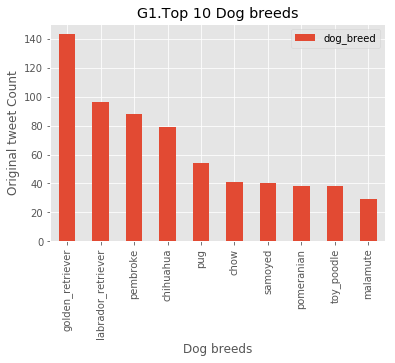

In [2093]:
style.use('ggplot')
#plt.figure(figsize=(10,6))
top_dog=fav_breeds.dog_breed.value_counts().sort_values(ascending=False).head(10)
top_dog.plot(kind='bar');
plt.xlabel('Dog breeds')
plt.ylabel('Original tweet Count')
plt.title('G1.Top 10 Dog breeds')
plt.legend();

*Golden retriver comes on top of popularity chart of dog breeds with larger populace owning this breed, tweeting to WeRateDogs to get them rated.*



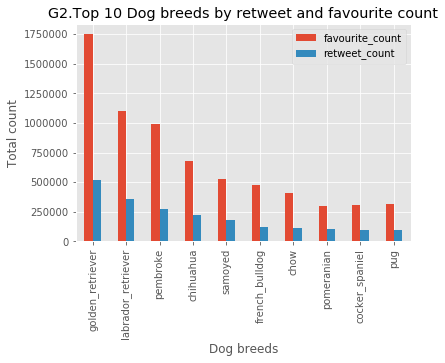

In [2094]:
plt.figure(figsize=(10,6))
fav_breeds.groupby('dog_breed')[['favourite_count','retweet_count']].sum().sort_values('retweet_count',ascending=False).head(10).plot(kind='bar');
plt.xlabel('Dog breeds')
plt.ylabel('Total count')
plt.title('G2.Top 10 Dog breeds by retweet and favourite count');
plt.legend();

In [2092]:
#fav=fav_breeds.groupby('dog_breed')[['favourite_count','retweet_count']].sum().sort_values('retweet_count',ascending=False).head(10)
fav[['favourite_count','retweet_count']].describe()

,favourite_count,retweet_count
count,1.000000e+01,10.000000
mean,6.861942e+05,208208.800000
std,4.685071e+05,139027.152711
min,3.024170e+05,95964.000000
25%,3.360738e+05,108138.500000
50%,5.033185e+05,150347.500000
75%,9.137430e+05,260421.000000
max,1.749528e+06,516903.000000


*Looking at graphs G1 and G2 we see that of the top 5,the top 4 dog breeds continue to trend, however pug seems to be pulled down to 10th place in terms of retweet and favourite count.*

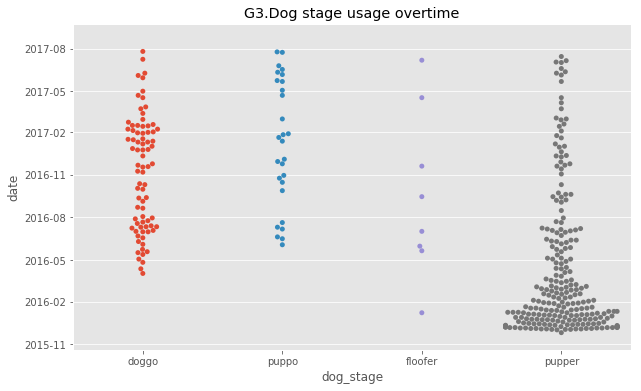

In [2096]:
#Dog stage popularity overtime
plt.figure(figsize=(10,6))
sns.swarmplot(x="dog_stage", y="date", data=dog_pred);
plt.title('G3.Dog stage usage overtime');

*Pupper seems to be the earliest dogstage term popularised by WeRateDogs and widely used.The usage gradually has declined with doggo gaining a fair share of popularity.Puppo comes third ,followed by floofer.*

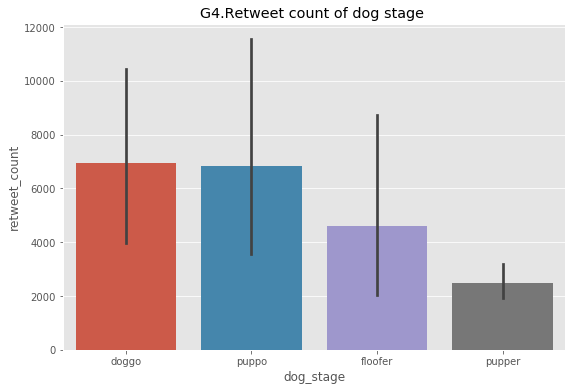

In [2099]:
#sns.barplot(x="dog_stage", y="retweet_count", data=fav_breeds,ci=None);
plt.figure(figsize=(9,6))
sns.barplot(x="dog_stage", y="retweet_count", data=fav_breeds);
plt.title('G4.Retweet count of dog stage ');

In [2100]:
#Statistic summary
dog_pred.groupby('dog_stage')['date'].describe()

,count,unique,top,freq,first,last
dog_stage,,,,,,
doggo,80,74,2017-01-11 00:00:00,2,2016-04-02 00:00:00,2017-07-26 00:00:00
floofer,8,8,2016-11-20 00:00:00,1,2016-01-08 00:00:00,2017-07-07 00:00:00
pupper,235,160,2015-12-07 00:00:00,5,2015-11-26 00:00:00,2017-07-15 00:00:00
puppo,28,28,2017-01-29 00:00:00,1,2016-06-03 00:00:00,2017-07-25 00:00:00


*Though pupper has the highest count and the earliest.newer terms -doggo and puppo have taken off with more retweets.*

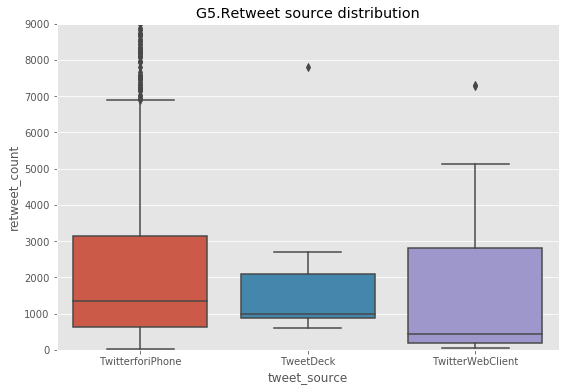

In [2103]:
#Most commonly used utility for tweeting by WeRateDogs
plt.figure(figsize=(9,6))
sns.boxplot(x="tweet_source", y="retweet_count",  data=dog_ratings_cleaned, dodge=False);
plt.ylim(0, 9000)
plt.title('G5.Retweet source distribution');

*Twitter for iphone ,WeRateDogs is an Apple fan*

In [2046]:
fav_breeds.set_index('date',inplace=True)

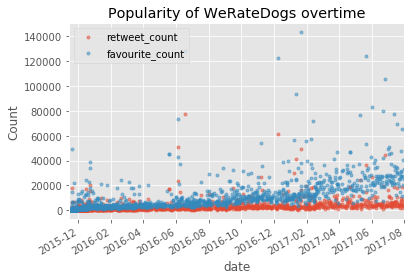

In [2109]:
#Popularity of WeRateDogs overtime
plt.figure(figsize=(10,6));
fav_breeds[['retweet_count','favourite_count']].plot(style = '.',alpha=0.5)
plt.ylabel('Count')
plt.title('Popularity of WeRateDogs overtime');

*WeRateDogs has gained popularity overtime*